# Time to Train my first LLM
---



## Setup

In [18]:
# install unsloth and pandas
#!pip install unsloth
#!pip install pandas

In [19]:
# checking if I can use my gpu
import torch
torch.cuda.is_available()

True

In [20]:
# import the libs that our teacher told us to
from unsloth import FastLanguageModel
import torch

In [21]:
# set the max number of tokens that can be passed in per chunk
max_seq_length = 2048

# let unsloth select our data type for us
dtype = None

# enable 4-bit quantization
# less memory but slightly less accuracy its just some math stuff
load_in_4bit = True

In [22]:
#from google.colab import drive
#drive.mount('/content/drive')

In [23]:
# find path to my data
#!ls 'drive/MyDrive/intro to AI/Notebooks'

In [24]:
import json
import pandas as pd
from datasets import Dataset

# connect to our data path
#dataPath = 'drive/MyDrive/intro to AI/Notebooks/allMethodsCombined.json'

dataPath = '../data/allMethodsCombined.json'

# load and convert to DataFrame
with open(dataPath, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)  # <- make it a DataFrame

# save the DataFrame to CSV
df.to_csv('allMethodsCombined.csv', index=False)

# convert to a hf dataset
dataset = Dataset.from_pandas(df)


In [25]:
# make a 2 col dataset
df2col = df[['code', 'javadoc']]

dataset2col = Dataset.from_pandas(df)


In [26]:
df2col.head(4)

,code,javadoc
0,public Point getLoc(){return location;},/*** Gets the location.\n*\n* @return the current location\n*/
1,"public void draw(Graphics g){\ng.setColor(color);\ng.fillOval(location.intX() - radius, location.intY() - radius, radius * 2, radius * 2);\nif (!active){\nVector standard_vec = move.normalize().scale(radius * 2);\ng.setColor(Color.RED);\ng.drawLine(location.intX(), location.intY(), standard_vec.move(location).intX(), standard_vec.move(location).intY());\n}\n}\n\n/* Make a Ball with the same features as this ball.\n* @see java.lang.Object#clone()\n*/\n@Override\npublic Ball clone() {\ntry {\nreturn (Ball)super.clone();\n}catch (CloneNotSupportedException cnse) {\nthrow new RuntimeException\n(""This class does not Implament Cloneable"");\n}\n\n}","/*** Draws the ball, and if non-active also draws its vector.\n*\n* @param g the Graphics context on which to draw\n*/"
2,public boolean isDone(){\nreturn finishedInstructions == totalInstructions;},"/*** Checks if the process is completed.\n* @return true, if is done */"
3,public void performInstruction(){\nif (!isDone())\nfinishedInstructions++;\n},/**Perform a single instruction of the process. */


## Model Selections:
- Qwen 2.5 coder (0.5b)
- Codellama (7b)
- Wizardcoder (33b)


In [27]:
# models from hugging face
model1 = 'Qwen/Qwen2.5-Coder-0.5B-Instruct'
model3 = 'codellama/CodeLlama-7b-hf'


## Fine tuning Qwen 2.5 Coder (0.5B)

### Setting up model

In [28]:
model, tokenizer = FastLanguageModel.from_pretrained(
    # qwen coder 0.5b
    model_name= model1,
    max_seq_length=max_seq_length,
    dtype = dtype,
    # give each model 4bit quantization or however you spell it
    load_in_4bit= True
)

==((====))==  Unsloth 2025.4.3: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3080 Ti. Num GPUs = 1. Max memory: 12.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu118. CUDA: 8.6. CUDA Toolkit: 11.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Establish How the model will learn

In [29]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj","k_proj","v_proj","o_proj",
                    "gate_proj","up_proj","down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

### Create a prompt for our dataset 

In [30]:
from langchain.prompts import PromptTemplate

multiShot = PromptTemplate(
    input_variables=["method_code","javadoc"],
    template='''\
Write a professional Javadoc comment for the following Java method. Only tell me the javadoc, **do not return any code.** 

Example 1:
Method:
public String reverseProcessed(String text) {{
    if (text == null) return null;
    String cleaned = text.trim().toLowerCase();
    return new StringBuilder(cleaned).reverse().toString();
}}

Javadoc:
/**
 * Reverses the characters in the given string after trimming whitespace and converting to lowercase.
 *
 * @param text the input string to process
 * @return the reversed, lowercase, trimmed string
 */

Example 2:
Method:
private int add(int a, int b) {{
    return a + b;
}}

Javadoc:
/**
 * Adds two integers.
 *
 * @param a the first integer
 * @param b the second integer
 * @return the sum of the two integers
 */

Now write a Javadoc comment for this method:
Method:
{method_code}

Expexted Javadoc:
{javadoc}

Javadoc:
'''
)

In [31]:
def format_with_prompt(example):
    return {
        "codeWithPrompt": multiShot.format(
            method_code=example["code"],
            javadoc=example["javadoc"]
        )
    }

finalDataset = dataset2col.map(format_with_prompt)

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

In [32]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

finalDataset.select(range(1)).to_pandas()


,javadoc,code,method_name,parameters,return_type,return_variable,called_methods,local_variables,thrown_exceptions,class_name,codeWithPrompt
0,/*** Gets the location.\n*\n* @return the current location\n*/,public Point getLoc(){return location;},getLoc,,Point,location,[],[location],[],Ball,"Write a professional Javadoc comment for the following Java method. Only tell me the javadoc, **do not return any code.** \n\nExample 1:\nMethod:\npublic String reverseProcessed(String text) {\n if (text == null) return null;\n String cleaned = text.trim().toLowerCase();\n return new StringBuilder(cleaned).reverse().toString();\n}\n\nJavadoc:\n/**\n * Reverses the characters in the given string after trimming whitespace and converting to lowercase.\n *\n * @param text the input string to process\n * @return the reversed, lowercase, trimmed string\n */\n\nExample 2:\nMethod:\nprivate int add(int a, int b) {\n return a + b;\n}\n\nJavadoc:\n/**\n * Adds two integers.\n *\n * @param a the first integer\n * @param b the second integer\n * @return the sum of the two integers\n */\n\nNow write a Javadoc comment for this method:\nMethod:\npublic Point getLoc(){return location;}\n\nExpexted Javadoc:\n/*** Gets the location.\n*\n* @return the current location\n*/\n\nJavadoc:\n"


### Start Training (Can be changed)

In [33]:
def formatting_func(example):
    return [f"{example['codeWithPrompt']} {example['javadoc']}"]


In [34]:
from unsloth import is_bfloat16_supported, UnslothTrainingArguments
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=finalDataset,
    dataset_text_field="codeWithPrompt",
    formatting_func=formatting_func,
    max_seq_length=512,
    dataset_num_proc=1,
    packing=True,
    args=UnslothTrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=16,
        warmup_steps=50,
        max_steps=150,
        learning_rate=2e-5,
        lr_scheduler_type="cosine",
        optim="adamw_8bit",
        weight_decay=0.1,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        save_steps=250,
        save_total_limit=2,
        output_dir="outputs",
        report_to=[],
        seed=3407,
    ),
)


Unsloth: Tokenizing ["codeWithPrompt"]:   0%|          | 0/228 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


In [35]:
# actually do the training
# this will take a while
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 228 | Num Epochs = 11 | Total steps = 150
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 8,798,208/5,000,000,000 (0.18% trained)


Step,Training Loss
10,0.040600
20,0.036100
30,0.018900
40,0.009600
50,0.005300
60,0.002700
70,0.001500
80,0.001800
90,0.001000
100,0.000500


TrainOutput(global_step=150, training_loss=0.008071566289290786, metrics={'train_runtime': 592.7136, 'train_samples_per_second': 4.049, 'train_steps_per_second': 0.253, 'total_flos': 1603071634291200.0, 'train_loss': 0.008071566289290786})

### Vizualize Training 

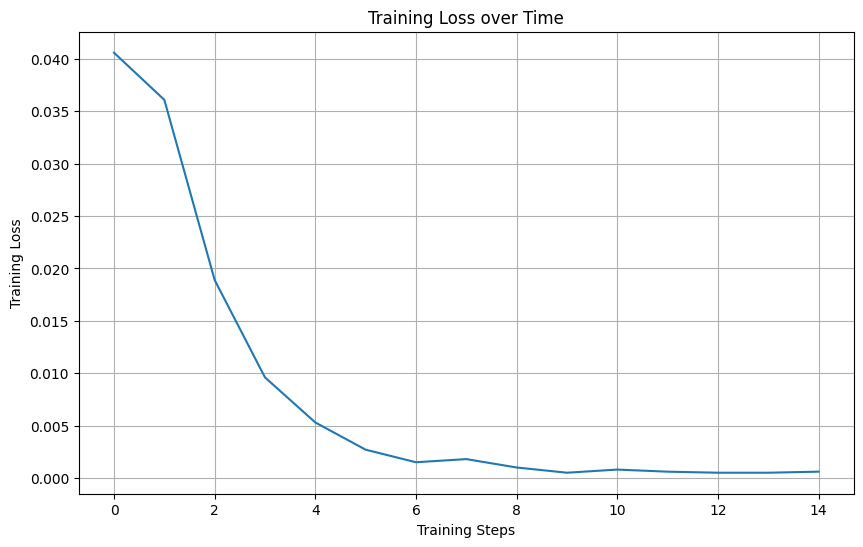

In [38]:

import matplotlib.pyplot as plt
import numpy as np
# After training is complete
training_logs = trainer.state.log_history
# Extract loss values
train_losses = [log.get('loss') for log in training_logs if 'loss' in log]
steps = list(range(len(train_losses)))
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses)
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()


## Upload to Hugging Face

In [37]:
from huggingface_hub import login

# Log in first (you only need to do this once)
login()

# Push model
model.push_to_hub("Eyas1/fine_tuned_qwen_java_docs")
tokenizer.push_to_hub("Eyas1/fine_tuned_qwen_java_docs")


  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/35.2M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Eyas1/fine_tuned_qwen_java_docs


README.md:   0%|          | 0.00/628 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]